# Don't append rows to a pandas DataFrame
Most beginning pandas users encounter a situation where choosing to append a row to a `DataFrame` seems like a good idea. A quick search of the API (or your favorite search engine) reveals that pandas has an `append` method in `DataFrame`. You may be tempted to use it. In this article I'll show you why you should not use `append`, how you _should_ grow your `DataFrame`, and a tip to make it faster.

Since pandas version 1.4.0, the `append` method has been deprecated, and this is called out in the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html). The recommended solution is to use `concat`, but there's a little more to the idea of growing a `DataFrame` than just blindly calling `concat`. Let's dig into some examples to see why.

## An example
Let's say we have a `DataFrame` with [time series](https://www.wrighters.io/indexing-time-series-data-in-pandas/) data. That just means that the index is a `datetime`, and in our case, it has one row per day. 

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.rand(365,3), index=pd.date_range('1999-01-01', periods=365), columns=list('ABC'))

df.tail()

,A,B,C
1999-12-27,0.731785,0.737431,0.422735
1999-12-28,0.378716,0.880707,0.775295
1999-12-29,0.002116,0.417487,0.427373
1999-12-30,0.012588,0.455592,0.022638
1999-12-31,0.026779,0.337595,0.894299


This is fabricated data, but you could imagine that you have a data file with data for each year, month, or week, for example. Now let's say that the approach you choose is is to load the first data file into a `DataFrame`, then load each file (as a `DataFrame`) and append it your initial `DataFrame`. How would `append` work?

In [2]:
# data for year 2000
df2 = pd.DataFrame(np.random.rand(365,3), index=pd.date_range('2000-01-01', periods=365), columns=list('ABC'))
df_combined = df.append(df2)

print(df_combined.shape)
df_combined.tail()

(730, 3)


<ipython-input-2-58251cd78b0a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df.append(df2)


,A,B,C
2000-12-26,0.900865,0.054083,0.103369
2000-12-27,0.433142,0.325692,0.412640
2000-12-28,0.877837,0.766650,0.244791
2000-12-29,0.095600,0.821537,0.685641
2000-12-30,0.095580,0.501606,0.856036


## `append` is deprecated
The first thing we see is that since I'm running pandas >= 1.4.0, there is a deprecation warning. It's telling us to switch from `append` to `concat`. So if all you want to know is how you should append rows to an existing `DataFrame`, use `pd.concat`.

## How to use `pd.concat`
`pd.concat` takes a list of pandas objects to concatenate as the only required argument. If you call it this way, it will use the index on the objects (they could be `DataFrame`s or `Series`) you pass in, and concatenate them along the `0` (or `index`) axis. If you pass in `1` (or `columns`) as the `axis` argument, it will grow the `DataFrame` by adding columns. 

You also should know about the `ignore_index` parameter. This is `False` by default, but if the indexes overlap on your objects (for example, if you have a default index on your `DataFrame`s and truly intend to just have those rows added at the end), then you should set that to `True`.

It also takes a `join` argument, which defaults to `outer`. This means that missing values in one `DataFrame` will be created in the resulting `DataFrame` but with `NaN` values.

There are other arguments which can be useful, check the [docs on merging](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) for some good examples.

In [3]:
pd.concat([df, df2])

,A,B,C
1999-01-01,0.190596,0.369787,0.503640
1999-01-02,0.407761,0.114384,0.044529
1999-01-03,0.782395,0.578529,0.426242
1999-01-04,0.996079,0.796410,0.246697
1999-01-05,0.409903,0.112034,0.602407
...,...,...,...
2000-12-26,0.900865,0.054083,0.103369
2000-12-27,0.433142,0.325692,0.412640
2000-12-28,0.877837,0.766650,0.244791
2000-12-29,0.095600,0.821537,0.685641


## Building up a `DataFrame`
OK, now that you know the right answer to combining multiple `DataFrame`s into one `DataFrame`, you know enough to use the _correct_ method. But what about the situation where you end up getting multiple rows or smaller `DataFrame`s one at a time and want to build one larger `DataFrame`? How should you do that?

Let's start with a simple example of our time series data, pretending we get one file per year.

In [4]:
%%timeit
df_all = pd.DataFrame()
for y in range(1999, 2023):
    # pretend we're loading these from a file or API or database
    df_y = pd.DataFrame(np.random.rand(365,3), index=pd.date_range(f'{y}-01-01', periods=365), columns=list('ABC'))
    # the temptation is to do this:
    #  df_combined = df_combined.append(df_y)
    df_all = pd.concat([df_all, df_y])

11.9 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## A better way
That works. But a better way to do it is to do the `pd.concat` only one time. 

In [5]:
%%timeit
data = []
for y in range(1999, 2023):
    data.append(pd.DataFrame(np.random.rand(365,3), index=pd.date_range(f'{y}-01-01', periods=365), columns=list('ABC')))
df_all = pd.concat(data)

7.2 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You might think, "What's the big deal, it's only a few more milliseconds"? Well, this is a trivial example of 365 data points. Let's build a more complete example with a bit more data. Let's say we have `DataFrame`s of size 1,000 x 1,000, and let's build them by calling `pd.concat` in two situations: once for each loop and only at the end. Let's also build an example where we start with a larger `DataFrame`, but only append one row.

(Note I set `ignore_index=True` here because each `DataFrame` will have the same default index.)

In [6]:
import datetime

start = datetime.datetime.now()
times = []
df_all = pd.DataFrame()
# appending each time
for y in range(100):
    df = pd.DataFrame(np.random.rand(1_000, 1_000))
    df_all = pd.concat([df_all, df], ignore_index=True)
    duration = datetime.datetime.now() - start
    times.append((duration, y))
print(f"{duration} to make final DataFrame of dimensions {df_all.shape} calling concat every iteration")

start = datetime.datetime.now()
times2 = []        
data = []      
# just making the DataFrames once in the loop
for y in range(100):
    df = pd.DataFrame(np.random.rand(1_000, 1_000))
    data.append(df)
    duration = datetime.datetime.now() - start 
    times2.append((duration, y))
# and then one big final concat
df_all2 = pd.concat(data, ignore_index=True)
duration = datetime.datetime.now() - start
times2.append((duration, y))
print(f"{duration} to make final DataFrame of dimensions {df_all2.shape} calling concat once")

start = datetime.datetime.now()
times3 = []
df_all3 = pd.DataFrame(np.random.rand(100_000, 1_000))
# appending each time, but just a single row
for y in range(100):
    one_row_df = pd.DataFrame(np.random.rand(1, 1_000))
    df_all3 = pd.concat([df_all3, one_row_df], ignore_index=True)
    duration = datetime.datetime.now() - start
    times3.append((duration, y))
print(f"{duration} to make final DataFrame of dimensions {df_all3.shape} calling concat every iteration")

0:00:27.403460 to make final DataFrame of dimensions (100000, 1000) calling concat every iteration
0:00:01.383713 to make final DataFrame of dimensions (100000, 1000) calling concat once
0:00:50.220051 to make final DataFrame of dimensions (100100, 1000) calling concat every iteration


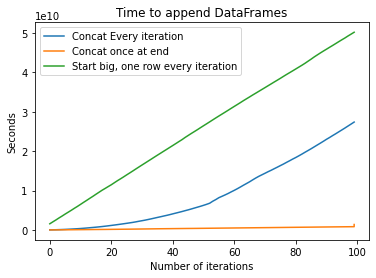

In [7]:
import matplotlib.pyplot as plt

axis = plt.subplot()
plt.plot(pd.DataFrame(times).set_index(1), label='Concat Every iteration')
plt.plot(pd.DataFrame(times2).set_index(1), label='Concat once at end')
plt.plot(pd.DataFrame(times3).set_index(1), label='Start big, one row every iteration')
axis.set_title('Time to append DataFrames')
axis.set_xlabel('Number of iterations')
axis.set_ylabel('Seconds')
axis.legend();

## Dramatic, isn't it?
Now that's pretty dramatic, and hopefully illustrates clearly the cost of naively appending to `DataFrame`s. If you append rows to an existing `DataFrame`, all the rows in the current `DataFrame` are copied each time you call append. If you start with a large `DataFrame` but only append one row in a loop, the time to add new rows will grow with the number of rows in the total `DataFrame`. If you are growing a `DataFrame` from scratch, it might seem fast enough in the beginning, but will bog down at large sizes.

Let's just take a step back and talk about what the problem is. The first and most important thing to realize is that appending to a `DataFrame` will make a copy of the data. This means that every time you call `pd.concat` (or the deprecated `append`) every row in the first `DataFrame` has to be copied once to the new result `DataFrame`. If you start with a `DataFrame` with N rows and append M rows or `DataFrame`s one at a time, you have to make NxM copies of just the original data, and this will be even worse if you are appending large chunks of data.

If we instead do one final concatenation, the NxM copies are reduced to just one final copy of the N rows.

So when you need to add data to your `DataFrame` and are tempted to do this in a loop, remember the correct way to do it and only call `pd.concat` once.